In [1]:
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Reshape, Lambda
from keras.layers.core import Dense, Flatten
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam, SGD
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os
import cv2
import h5py
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [0]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%cd "drive/My Drive/BTP"

/content/drive/My Drive/BTP


In [0]:
custom_objects = {'loss':euclidean_loss(beta), 
                  'euclidean_dist':euclidean_dist, 
                  'x_error':x_error, 
                  'y_error':y_error, 
                  'z_error':z_error}

def test_saved_model(path_to_model, x_test, y_test, custom_objects):
  model = load_model(path_to_model, custom_objects=custom_objects)
  metric_names = model.metric_names
  scores = model.evaluate(x_test, y_test, verbose=1)
  for metric, val in zip(metric_names, scores):
    print("{} : {}".format(metric, val))

In [0]:
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'vgg_50_epochs_adam_v2.h5'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, model_name)

In [0]:
from tensorflow.python.client import device_lib
assert 'GPU' in str(device_lib.list_local_devices())

In [0]:
from keras import backend
assert len(backend.tensorflow_backend._get_available_gpus()) > 0

In [0]:
K.clear_session()

In [0]:
img_width = 128
img_height = 128
channels = 3
batch_size = 1

In [4]:
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_width, img_height, channels))





58892288/58889256 [==============================] - 5s 0us/step








In [11]:
for layer in base_model.layers[:-4]:
    layer.trainable = False
    print (layer)

In [0]:
model = Sequential()
model.add(base_model)
#model.add(Flatten())
#model.add(Dense(6))

In [6]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [0]:
# beta = 0.001
# def euclidean_loss(beta):
#     def loss(y_true, y_pred):
#         return K.sqrt(K.sum(K.square(y_pred[:3] - y_true[:3]))) + beta * K.sqrt(K.sum(K.square(y_pred[3:] - y_true[3:])))
#     return loss

def euclidean_dist(y_true, y_pred):
  return K.sqrt(K.mean(K.square(y_pred[:,:3] - y_true[:,:3]), axis=1))

def x_error(y_true, y_pred):
  return K.mean(K.abs(y_pred[:,0] - y_true[:,0]))

def y_error(y_true, y_pred):
  return K.mean(K.abs(y_pred[:,1] - y_true[:,1]))

def z_error(y_true, y_pred):
  return K.mean(K.abs(y_pred[:,2] - y_true[:,2]))

In [0]:
beta = 0.001
def custom_loss(layer):
    def euclidean_loss(y_true, y_pred):
        return K.sqrt(K.sum(K.square(y_pred[:3] - y_true[:3]))) + beta * K.sqrt(K.sum(K.square(y_pred[3:] - y_true[3:])))
    return euclidean_loss

In [16]:
y_file = 'train_GT.csv'
y_train = np.loadtxt(y_file, dtype=np.float32)

x_file = 'train_set.hdf5'
h5_reader = h5py.File(x_file, 'r')
print(h5_reader.keys())
x_train = h5_reader['train_img']
x_train = np.array(x_train)
h5_reader.close()

KeysView(<HDF5 file "train_set.hdf5" (mode r)>)


In [17]:
print(type(x_train))
print("Shape of training set : ", x_train.shape)
x_train = x_train.astype('float32', copy=False)
x_train /= 255

<class 'numpy.ndarray'>
Shape of training set :  (26399, 128, 128, 3)


Shape of training labels :  (26399, 6)
<class 'numpy.ndarray'>
float32


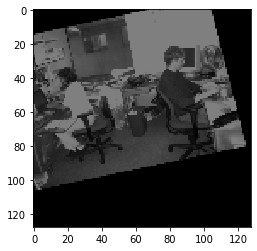

In [18]:
print('Shape of training labels : ', y_train.shape)
print(type(x_train[26200]))
print(x_train[26200].dtype)
plt.imshow(x_train[26200])


In [19]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD()
#model.compile(optimizer=adam, loss=euclidean_loss(beta=beta), metrics=[euclidean_dist, x_error, y_error, z_error])
model.compile(optimizer=adam, loss=custom_loss(layer), metrics=[euclidean_dist, x_error, y_error, z_error])

In [0]:
img_gen = ImageDataGenerator()
img_gen.fit(x_train)

In [21]:
epochs = 50
batch_size = 32
steps_per_epoch = x_train.shape[0] // batch_size
print(steps_per_epoch)

824


In [0]:
model.fit_generator(img_gen.flow(x_train, y_train, batch_size = batch_size), verbose=1, steps_per_epoch=steps_per_epoch, epochs=epochs)

In [0]:
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/My Drive/BTP/saved_models/vgg_50_epochs_sgd.h5 


In [0]:
x_file = 'test_set.hdf5'
h5_reader = h5py.File(x_file, 'r')
print(h5_reader.keys())
x_test = h5_reader['test_img']
x_test = np.array(x_test)
h5_reader.close()
x_test = x_test.astype('float32')
x_test /= 255

KeysView(<HDF5 file "test_set.hdf5" (mode r)>)


In [0]:
y_file = 'test_GT.csv'
y_test = np.loadtxt(y_file, dtype=np.float32)

In [0]:
print(x_test.shape)
print(y_test.shape)

(6600, 128, 128, 3)
(6600, 6)


In [0]:
#h5mod = h5py.File(model_path, 'r')
# layer = 0
# def custom_loss(layer):
#     def euclidean_loss(y_true, y_pred):
#         return K.sqrt(K.sum(K.square(y_pred[:3] - y_true[:3]))) + beta * K.sqrt(K.sum(K.square(y_pred[3:] - y_true[3:])))
#     return euclidean_loss
mod = load_model(model_path, custom_objects={'euclidean_loss':custom_loss(layer), 'euclidean_dist':euclidean_dist, 'x_error':x_error, 'y_error':y_error, 'z_error':z_error})

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [0]:
print(mod.metrics_names)

['loss', 'euclidean_dist', 'x_error', 'y_error', 'z_error']


In [0]:
score = mod.evaluate(x_test, y_test, verbose=1)

6600/6600 [==============================] - 8s 1ms/step


In [0]:
print(score)

[0.2662534994067568, 0.009894702524849863, 0.008567998440879764, 0.007702304710718718, 0.009683564418193066]


###Visualize the dataset

In [0]:
datagen = ImageDataGenerator()
datagen.fit(x_train)
X_iter = datagen.flow(x_train, y_train, batch_size=1)
rows, columns = 3, 3
print(type(X_iter))
fig = plt.figure(figsize=(10,10))
for i in range(1, rows*columns+1):
    img, label = next(X_iter)
    img = img.reshape((img.shape[1:]))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)

plt.show()